# Running RADMC-3D with AggScatVIR

One primary application of ``AggScatVIR`` is the observational modeling of both total-intensity and polarized scattered light from protoplanetary disks and debris disks. Our database has been designed to allow users to easily conduct radiative transfer simulations with [RADMC-3D](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/), a publicly available radiative transfer simulation code. As our dust data files have a data structure that is directly readable by RADMC-3D v2.0, RADMC-3D can be run without further data processing. To use one of our dust models with RADMC-3D, simply place it (dustkapscatmat_XXX.inp) in a directory that RADMC-3D will be running. Once the necessary input files have been properly prepared (as described below), you will be ready to run RADMC-3D.

## Quick demo using radmc3dPy

Please ensure that RADMC-3D has been installed on your system before proceeding. If not, refer to [the RADMC-3D manual](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/) for installation instructions. Once RADMC-3D is installed, go to the directory where you wish to run RADMC-3D. Select one of our dust model files (dustkapscatmat_XXX.inp) and place it in your working directory. For example, we have made a local copy of ``dustkapscatmat_FA19_Nmax2048_100nm_amc_chop5.inp``. To prepare the remaining necessary files for RADMC-3D, we will utilize radmc3dPy, which is also included in RADMC-3D. To do so, we must import the necessary module for radmc3dPy.

In [1]:
from radmc3dPy import *

Then write a default parameter set for a typical protoplanetay disk:

In [2]:
analyze.writeDefaultParfile('ppdisk')

Writing problem_params.inp


It would be safe to set the wavelength grid in the radiative transfer calculation (specified in wavelength.inp) to be consistent with the wavelength coverage of the dust file provided by this database. Therefore, let's set the short and long wavelength ends to be 0.554 and 3.78 $\mu$m, respectively.

In [3]:
nw='[1,1,1,1,1,2]' 
wbound='[0.554,0.735,1.040,1.250,1.630,2.180,3.780]' 

To create a scattered-light image using RADMC-3D, we need a dust temperature file (dust_temperature.dat or dust_temperature.bdat) in the working directory. Generally, RADMC-3D has a mode for determining the radiation equilibrium temperature of dust particles (mctherm), and the dust temperature file will be generated after running mctherm. **However, the wavelength coverage of this database is too narrow to determine the correct temperature, so mctherm cannot determine the correct temperature**. Therefore, the user must manually create the dust temperature file.

In this section, we omit the contribution of thermal emission, and therefore set the dust temperature to 0 K everywhere in the simulation cells. Such a dust temperature file can be created after running mctherm with no-photon packets by setting (``nphoto='int(0)'``).

We can create necessary input files for RADMC-3D by running the following command:

In [4]:
setup.problemSetupDust('ppdisk', mdisk='1e-4*ms',rin='10*au',
                      nw=nw,wbound=wbound,xbound='[10.0*au,10.5*au, 100.0*au]',\
                       nz='[64]',\
                       dustkappa_ext ="['FA19_Nmax2048_100nm_amc_chop5']",\
                       nphot='int(0)',nphot_scat='int(1e6)',scattering_mode_max=5)

Writing problem_params.inp
Writing dustopac.inp
Writing wavelength_micron.inp
Writing amr_grid.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.044969e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing dust_density.binp
Writing radmc3d.inp


Please make sure to (i) specifiy the filename extension (XXX in dustkapscatmat_XXX.inp) and (ii) include ``scattering_mode_max=5``.

Now we are ready to run RADMC-3D. Let's start running mctherm first (Again, no photon packets will be launched in this step. This is just to create a dust temperature file that is needed to scattering Monte Carlo run).

In [5]:
import os
os.system('radmc3d mctherm')

0

This command ends up with creating a dust_temperature files (``dust_temperature.bdat``).

We can create a scattered-light image by performing a scattering Monte Carlo simulation. Let's do imaging at an optical wavelength of (0.6 $\mu\mathrm{m}$) and a disk inclination angle of 55 degrees:

In [6]:
image.makeImage(npix=300., wav=0.6, incl=55, sizeau=250.,stokes=True)

Executing RADMC-3D Command:
radmc3d image npix 300 incl 55 sizeau 250.0 lambda 0.6 pointau 0.0  0.0  0.0 fluxcons stokes


0

It will take about 50 seconds to complete using a single core, and ``image.out`` will be created in the end. The file contains intensity of the four Stokes components at each image pixel. The resultant total-intensity disk image looks like this:

Reading image.out


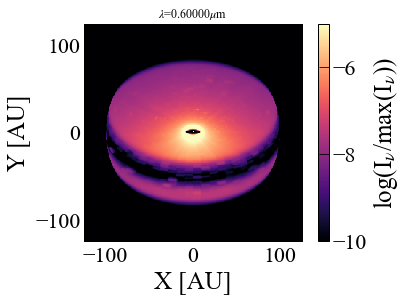

{'implot': <matplotlib.image.AxesImage at 0x7f95a69102b0>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f95ab8c60a0>}

In [7]:
import matplotlib.pylab as plb
im = image.readImage()
image.plotImage(im, au=True, log=True, saturate=1e-5,maxlog=10,cmap="magma")

Let's try another parameters: at a wavelength of $\lambda=2.2~\mu$m and a disk inclination angle of 85 degrees.

In [10]:
image.makeImage(npix=300., wav=2.2, incl=85, sizeau=250.,stokes=True)

Executing RADMC-3D Command:
radmc3d image npix 300 incl 85 sizeau 250.0 lambda 2.2 pointau 0.0  0.0  0.0 fluxcons stokes


0

After completing another round of the second hand of the clock, we obtain the following image:

Reading image.out


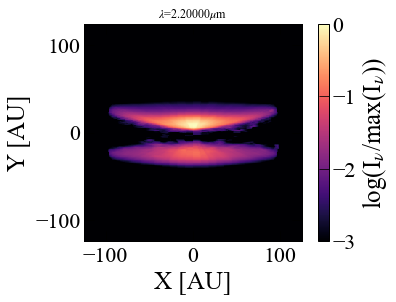

{'implot': <matplotlib.image.AxesImage at 0x7f95a9ae65b0>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f95a9d363a0>}

In [11]:
im = image.readImage()
image.plotImage(im, au=True, log=True, maxlog=3,cmap="magma")

These are the model images of scattered light of a disk containing fractal dust aggregates with sub-micron grains, although more photon packets/finer spatial grids would be needed to improve the image quality. These images will then be used to compare actual scattered-light images of disks, from which we may understand how dust coagulation proceeds in disks as well as the initial condition of dust coagulation (the radius and composition of monomers).

## Preparation of input files and caveats

Here we summarize the points to consider when generating the input files in more detail. Of the RADMC-3D input files, the following three are relevant to using our dust model: ``radmc3d.inp``, ``dustopac.inp``, ``wavelength.inp``.

``dustopac.inp`` sets how RADMC-3D will read dust input files. To use the dustkapscatmat_XXX.inp file, the inputstype in ``dustopac.inp`` must be set to 10. The extension XXX of the dust file must also be set in this file.

``radmc3d.inp`` is where the scattering Monte Carlo calculation mode can be set. To run the scattering Monte Carlo calculations taking into account all Stokes parameters, scattering_mode_max = 5 must be set.

``wavelength.inp`` contains the wavelength grids used in the radiative transfer calculation. Since the scattering Monte Carlo calculation is monochromatic, there will be no problem if the wavelength used for imaging is within the wavelength range of the dust file. However, if mctherm is run in advance as done in the above example, the wavelength grid is better set to agree with the wavelength coverage of dust files; otherwise, RADMC-3D might cause some internal errors when reading dust opacity files.

.. important:: **Thermal Monte Carlo runs**: As already mentioned in the above example, dust files provided in AggScatVIR have a wavelength coverage too narrow to determine radiation equillibrium temperature via thermal Monte Carlo calculations (``mctherm`` in RADMC-3D). *Therefore, it is recommended to use the package for monochromatic scattering Monte Carlo radiative transfer simulations.*

.. warning:: **Models with incomplete wavelength coverage**: The following models only have the wavelength coverage of 1.04-3.78 microns; therefore, the data sets at 0.554 and 0.735 microns are missing:
   ``FA19_(Nmax)4096_100nm_amc``,
   ``FA19_(Nmax)4096_100nm_org``,
   ``FA15_(Nmax)1024_100nm_amc``,
   ``FA15_(Nmax)1024_100nm_org``,
   ``FA13_(Nmax)512_100nm_amc``,
   ``FA13_(Nmax)512_100nm_org``,
   ``FA11_(Nmax)256_100nm_amc``, 
   ``FA11_(Nmax)256_100nm_org``.


.. seealso:: **Chopping forward scattering**: Dust particles much larger than the wavelength may exhibit a strong forward scattering, which may cause some issues in your simulations, such as poor image quality. One approximate  way to mitigate this issue is to chop the forward scattering peak off. For this purpose, ``AggScatVIR`` offers the dustkapscatmat_XXX.inp file with two different chopping angles: 5 and 10 degrees. When you encounter the issue, please consider using those files.